# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: 
***Omri Newman: 806646***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import random

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

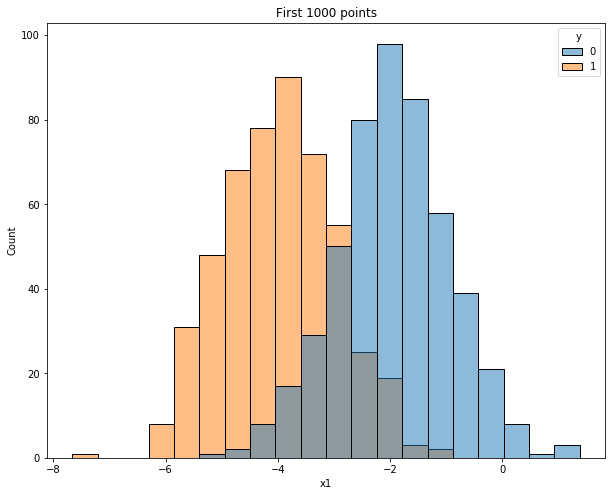

In [4]:
import seaborn as sns

sns.histplot(data=training_set.iloc[:1000], x='x1', hue='y',
            bins=20, alpha=0.5)
plt.title("First 1000 points");

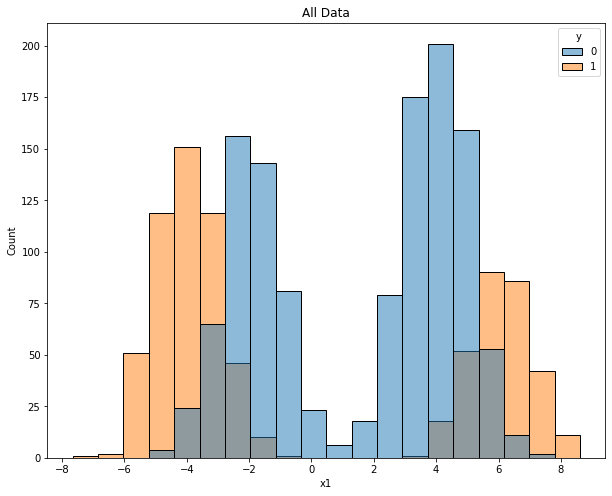

In [5]:
sns.histplot(data=training_set, x='x1', hue='y',
            bins=20, alpha=0.5)
plt.title("All Data");

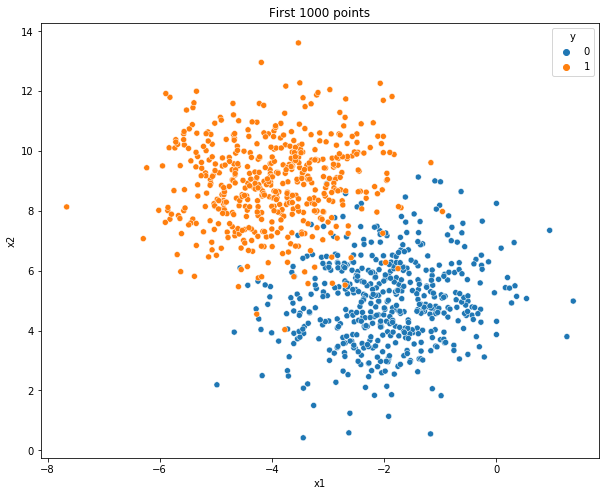

In [6]:
sns.scatterplot(data=training_set.iloc[:1000], x='x1', y='x2', hue='y')
plt.title("First 1000 points");

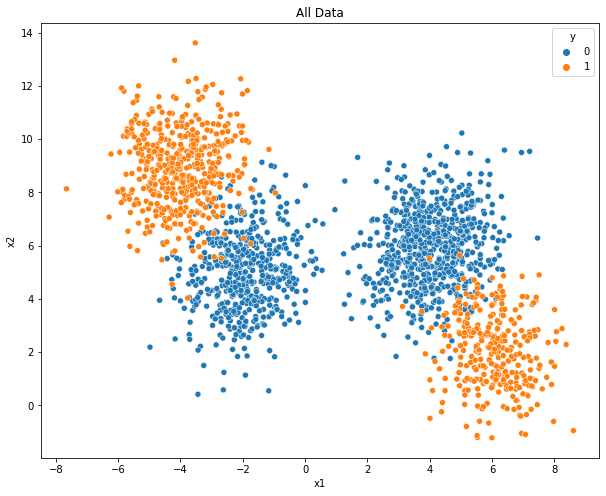

In [7]:
sns.scatterplot(data=training_set, x='x1', y='x2', hue='y')
plt.title("All Data");

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

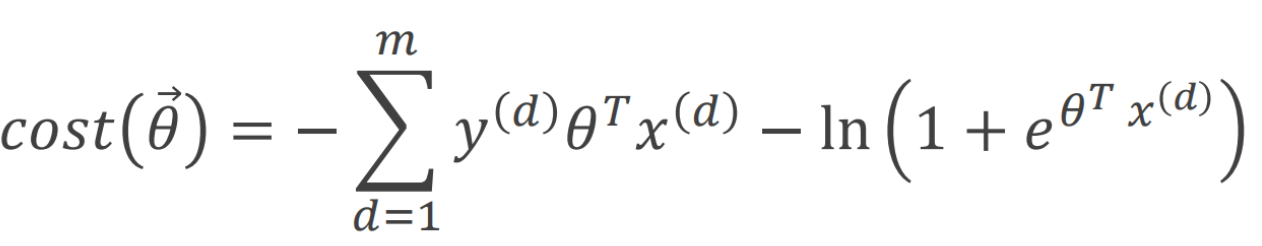

In [8]:
def compute_cost(X, y, theta):
    """
    Computes the cross entropy loss between an obserbation's actual and
    predicted values for logistic regression.  

    Input:
    - X: inputs  (n features over m instances).
    - y: true labels (1 value over m instances).
    - theta: the parameters (weights) of the model being learned.

    Returns a single value:
    - J: the cost associated with the current set of parameters (single number).
    """
    J = -np.sum((y * (X @ theta)) - (np.log(1 + np.exp(X @ theta))))
    return J

In [9]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = None
        self.m = None
        self.J_history = []

    def sigmoid(self, x):
        exponent = np.exp(x)
        return exponent / (1 + exponent)
    
    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        np.random.seed(self.random_state)
        X = np.c_[np.ones(len(X)), X]
        self.theta = np.random.random(X.shape[1])

        delta_J = float('inf')
        m = len(X) 
        i = 0

        while delta_J > self.eps and i < self.n_iter:
            h = self.sigmoid(X @ self.theta)
            self.theta -= (self.eta) * X.T @ (h - y)

            J_i = compute_cost(X, y, self.theta)
            self.J_history.append(J_i)

            if len(self.J_history) > 1:
                delta_J = abs(self.J_history[i] - self.J_history[i - 1])

            i += 1

        return self.theta, self.J_history[1:]
    
    def predict(self, X):
        """Return the predicted class label"""
        X = np.c_[np.ones(len(X)), X]
        return (self.sigmoid(X@self.theta) > 0.5)*1
#         return np.round(self.sigmoid(X @ self.theta))
      

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [10]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

In [11]:
def cross_validation_split(dataset, folds=5):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [12]:
np.random.seed(100)
accuracy = []
split_dat = cross_validation_split(training_set.sample(frac=1).values)
for eta in etas:
    for eps in epss:
        for i in range(len(split_dat)):
            X = np.array(split_dat[i])[:, 0:2]
            y = np.array(split_dat[i])[:, 2]
            model = LogisticRegressionGD(eta=eta, eps=eps)
            model.fit(X, y)
            y_pred = model.predict(X)
            accuracy.append(np.mean(y_pred == y))         

In [13]:
import itertools

cross = list(itertools.product(etas, epss))

res = pd.DataFrame(list(zip(cross*5, accuracy))).rename(
    {0:"(eta,eps)", 1:"training accuracy (%)"}, axis=1)

res['training accuracy (%)'] = res['training accuracy (%)'] * 100

In [14]:
params = res[res["training accuracy (%)"] == res["training accuracy (%)"].max()]["(eta,eps)"].values[0]
# params = res[res["training accuracy (%)"] == res["training accuracy (%)"].max()].reset_index(drop=True).iloc[0].values[0]
best_eta = params[0]
best_eps = params[1]
best_eta, best_eps

(5e-06, 0.0001)

## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [15]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    return (1 / (((2*np.pi) ** 0.5)*sigma)) *  np.exp((-(data-mu)**2) / (2 * (sigma**2)))

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [16]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        
    def neg_log(self, likelihood):
        return -1 * np.sum(np.log(likelihood))

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        # random
        self.w = np.ones(self.k) / self.k
        self.mu = [np.mean(data)] * self.k
        self.sigma = [np.std(data)] * self.k
        self.resp = np.ones((data.shape[0],self.k))
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        # init with zeros
        likelihood = np.zeros((data.shape[0], self.k))
        
        for i in range(self.k):
            likelihood[:,i] = self.w[i] * norm_pdf(data, self.mu[i], self.sigma[i])
           
        self.resp = likelihood / likelihood.sum(axis=1)[:,None]
        return self.resp, likelihood
    
    def maximization(self, data):
        """
        M step - updating distribution params
        """
        self.w = np.mean(self.resp, axis=0)
        for i in range(self.k):
            self.mu[i] = np.mean(self.resp[:, i] * data) / self.w[i]
            self.sigma[i] = np.sqrt(np.mean(self.resp[:, i] * np.square(data - self.mu[i])) / self.w[i])
        
        return self.w, self.mu, self.sigma

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        #initialize
        self.init_params(data)
        
        self.cost = -np.inf
        
        for i in range(self.n_iter):
            self.resp, likelihood = self.expectation(data)
            
            prev_cost = self.cost
            self.cost = self.neg_log(likelihood)
            
            if np.abs(self.cost - prev_cost) <= (self.eps) or (np.isinf(self.cost)):
                break
            
            w_new, mu_new, sigma_new = self.maximization(data)
            self.w = w_new
            self.mu = mu_new
            self.sigma = sigma_new
    
            
    def get_dist_params(self):
        return self.mu, self.sigma, self.w
    

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [17]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gausian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        
        # get prior for both classes
        self.prior_0 = self.get_prior(y, 0)        
        self.prior_1 = self.get_prior(y, 1) 
        
        # get class indexes
        class_0 = (y==0)
        class_1 = (y==1)
        
        # EM 
        x00 = X[class_0, 0]
        self.em_00 = EM(k=self.k)
        self.em_00.fit(x00)
        
        x01 = X[class_0, 1]
        self.em_01 = EM(k=self.k)
        self.em_01.fit(x01)
        
        x10 = X[class_1, 0]
        self.em_10 = EM(k=self.k)
        self.em_10.fit(x10)
        
        x11 = X[class_1, 1]
        self.em_11 = EM(k=self.k)
        self.em_11.fit(x11)
    
    def predict(self, X):
        """Return the predicted class label"""
        likelihood00 = np.max(self.em_00.expectation(X[:,0])[1], axis=1)
        likelihood01 = np.max(self.em_01.expectation(X[:, 1])[1], axis=1)

        likelihood10 = np.max(self.em_10.expectation(X[:, 0])[1], axis=1)
        likelihood11 = np.max(self.em_11.expectation(X[:, 1])[1], axis=1)

        posterior_0 = self.prior_0 * likelihood00 * likelihood01
        posterior_1 = self.prior_1 * likelihood10 * likelihood11
        
        # return predictions : 1 when posterior_1 is greater than posterior_0, or 0 otherwise
        predictions = np.zeros_like(posterior_0)
        predictions[(posterior_1 > posterior_0)] = 1
        return predictions
    
    def get_prior(self, y, class_label):
        return len(y[:]==class_label)/ len(y[:])


## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

In [18]:
# Use the first 1000 points from the training set and the first 500 points from the test set.
xtrain1000 = X_training[:1000]
ytrain1000 = y_training[:1000]

xtest500 = X_test[:500]
ytest500 = y_test[:500]

In [19]:
# Fit Logistic Regression model with the best params you found earlier.
log_model_train = LogisticRegressionGD(eta=best_eta, eps=best_eps)
log_model_train.fit(xtrain1000, ytrain1000)

log_model_test = LogisticRegressionGD(eta=best_eta, eps=best_eps)
log_model_test.fit(xtrain1000, ytrain1000)

# Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM

nb_model_train = NaiveBayesGaussian(k=2)
nb_model_train.fit(xtrain1000,ytrain1000)

nb_model_test = NaiveBayesGaussian(k=2)
nb_model_test.fit(xtrain1000, ytrain1000)

In [20]:
# Print the training and test accuracies for each model.

#LR:
pred_log_train = log_model_train.predict(xtrain1000)
accuracy_log_train = np.mean(pred_log_train == ytrain1000)
print("Logistic Regression training accuracy:", accuracy_log_train * 100)
pred_log_test = log_model_test.predict(xtest500)
accuracy_log_test = np.mean(pred_log_test == ytest500)
print("Logistic Regression test accuracy:", accuracy_log_test * 100, "\n")

#NB:
pred_nb_train = nb_model_train.predict(xtrain1000)
accuracy_nb_train = (pred_nb_train.ravel() == ytrain1000).sum() / len(ytrain1000) * 100
print("Naive Bayes training accuracy:", accuracy_nb_train)
pred_nb_test = nb_model_test.predict(xtest500)
accuracy_nb_test = (pred_nb_test.ravel() == ytest500).sum() / len(ytest500) * 100
print("Naive Bayes testing accuracy:", accuracy_nb_test)


Logistic Regression training accuracy: 94.6
Logistic Regression test accuracy: 92.60000000000001 

Naive Bayes training accuracy: 96.6
Naive Bayes testing accuracy: 94.19999999999999


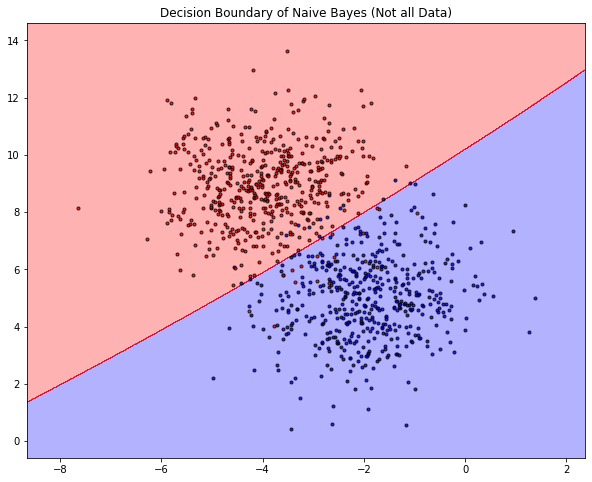

In [21]:
# use the plot_decision_regions function to plot the decision boundaries for each model
plot_decision_regions(xtrain1000, ytrain1000, nb_model_test)
plt.title("Decision Boundary of Naive Bayes (Not all Data)");

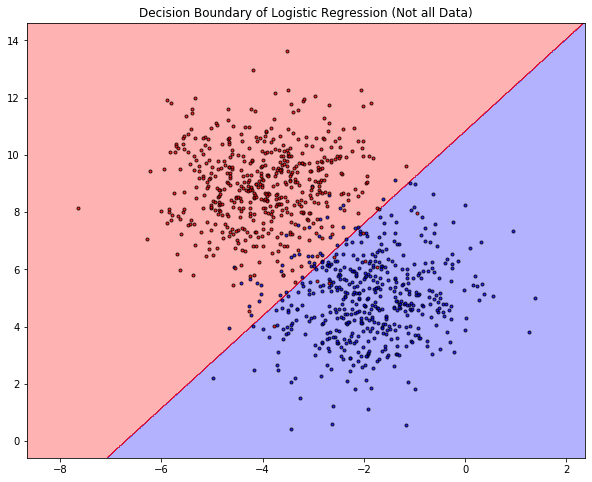

In [22]:
plot_decision_regions(xtrain1000, ytrain1000, log_model_test)
plt.title("Decision Boundary of Logistic Regression (Not all Data)");

Text(0, 0.5, 'Cost')

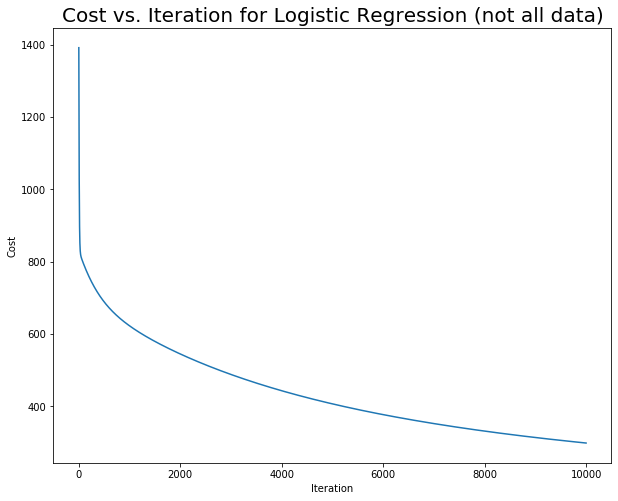

In [23]:
# Plot the cost Vs the iteration number for the Logistic Regression model
plt.plot(log_model_test.J_history)
plt.title("Cost vs. Iteration for Logistic Regression (not all data)", fontsize=20)
plt.xlabel("Iteration")
plt.ylabel("Cost")

In [24]:
# Repeat sections 2-6 for all the training set points

# LR

# best parameters keep changing even though we're using np.random.seed()
# hard coding the best parameters we initially found in order to maintain the 
# correct decision boundary below
# log_model = LogisticRegressionGD(eta=best_eta, eps=best_eps)
log_model_train = LogisticRegressionGD(eta=0.00005, eps=0.000001)
log_model_train.fit(X_training, y_training)

log_model_test = LogisticRegressionGD(eta=0.00005, eps=0.000001)
log_model_test.fit(X_training, y_training)

pred_log_train = log_model_train.predict(X_training)
accuracy_log_train = np.mean(pred_log_train == y_training) * 100
print("Logistic Regression training accuracy:", accuracy_log_train)
pred_log_test = log_model_test.predict(X_test)
accuracy_log_test = np.mean(pred_log_test == y_test) * 100
print("Logistic Regression testing accuracy:", accuracy_log_test)

# NB

nb_model_train = NaiveBayesGaussian(k=2)
nb_model_train.fit(X_training,y_training)

nb_model_test = NaiveBayesGaussian(k=2)
nb_model_test.fit(X_training, y_training)

pred_nb_train = nb_model_train.predict(X_training)
accuracy_nb_train = (pred_nb_train.ravel() == y_training).sum() / len(y_training) * 100
print("Naive Bayes training accuracy:", accuracy_nb_train)
pred_nb_test = nb_model_test.predict(X_test)
accuracy_nb_test = (pred_nb_test.ravel() == y_test).sum() / len(y_test) * 100
print("Naive Bayes testing accuracy:", accuracy_nb_test)

Logistic Regression training accuracy: 82.19999999999999
Logistic Regression testing accuracy: 81.69999999999999
Naive Bayes training accuracy: 87.55
Naive Bayes testing accuracy: 85.39999999999999


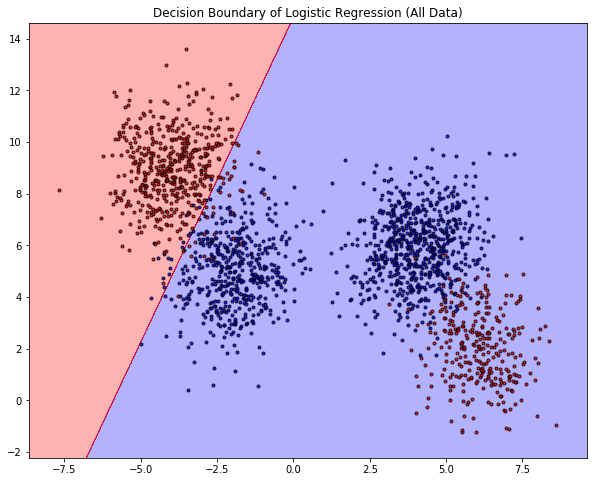

In [25]:
plot_decision_regions(X_training, y_training, log_model_test, resolution=0.01)
plt.title("Decision Boundary of Logistic Regression (All Data)");

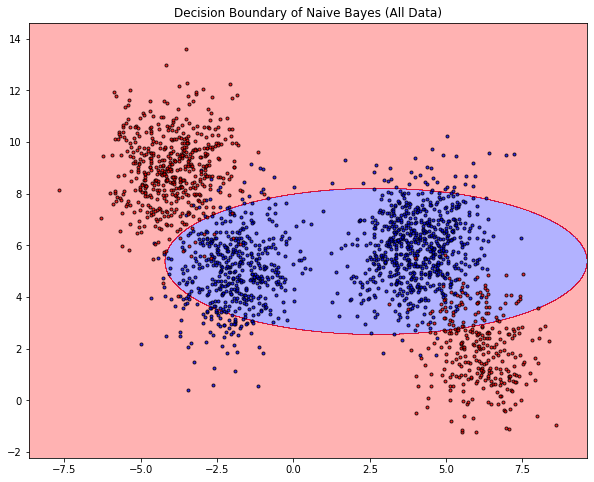

In [26]:
plot_decision_regions(X_training, y_training, nb_model_test, resolution=0.01)
plt.title("Decision Boundary of Naive Bayes (All Data)");

Text(0, 0.5, 'Cost')

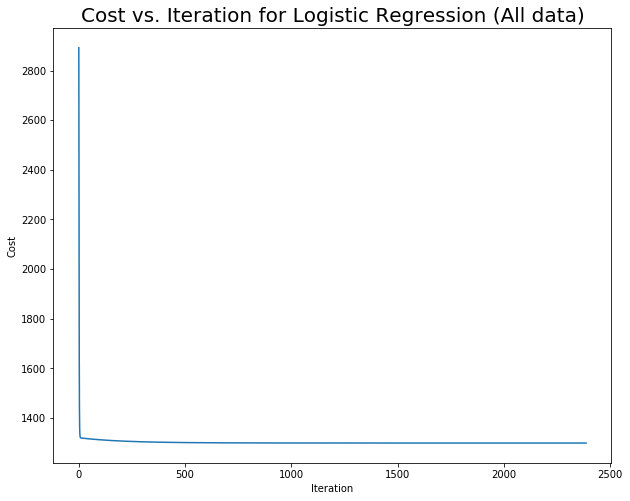

In [27]:
# Plot the cost Vs the iteration number for the Logistic Regression model
plt.plot(log_model_test.J_history)
plt.title("Cost vs. Iteration for Logistic Regression (All data)", fontsize=20)
plt.xlabel("Iteration")
plt.ylabel("Cost")

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work 
   better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####

For logistic regression to work better we want to work against the assumptions of Naive Bayes. Naive Bayes assumes independence so we need to create a dataset that is highly dependent (high covariance). Moreover logistic regression works better with linearly separable data. 

For Naive Bayes to work better we need data which is not linearly separable, because the model does not find a linear separator while logistic regression does. 

In [28]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [29]:
# independence
cov = np.array([[1,0,0],
               [0,1,0],
               [0,0,1]])

# dependent
cov2 = np.array([[1,3,9],
               [3,1,4],
               [9,4,1]])

mean_1 = np.array([1,1,1])
mean_2 = np.array([5,5,5])
mean_3 = np.array([9,9,9])

nb_1 = multivariate_normal.rvs(mean_1, cov, size=500)
nb_2 = multivariate_normal.rvs(mean_2, cov, size=500)
nb_3 = multivariate_normal.rvs(mean_3, cov, size=500)

log_1 = multivariate_normal.rvs(mean_1, cov2, size=500)
log_2 = multivariate_normal.rvs(mean_2, cov2, size=500)

pos = np.ones(500).astype(int)
neg = np.zeros(500).astype(int)

class_1 = np.c_[nb_1, pos]
class_2 = np.c_[nb_2, neg]
class_3 = np.c_[nb_3, pos]

log_class_1 = np.c_[log_1, pos]
log_class_2 = np.c_[log_2, neg]

NB = np.concatenate((class_1, class_2, class_3))
np.random.shuffle(NB)

LOG = np.concatenate((log_class_1, log_class_2))
np.random.shuffle(LOG)

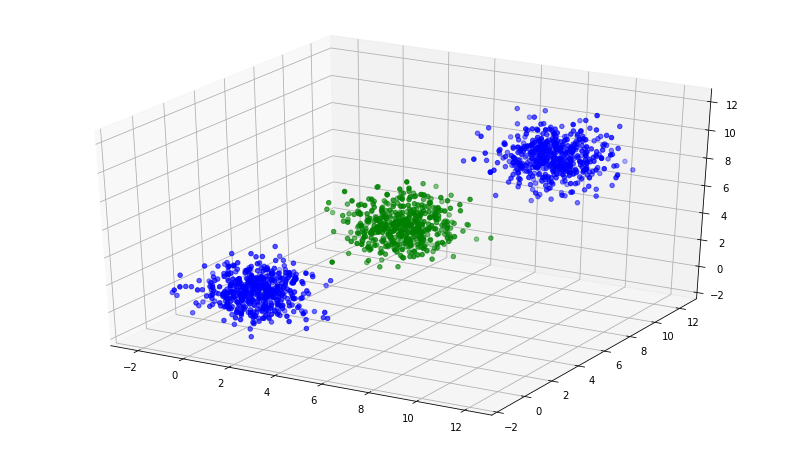

In [30]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(class_1[:,0], class_1[:,1], class_1[:,2], color='b', label='one')
ax.scatter(class_2[:,0], class_2[:,1], class_2[:,2], color='g', label='zero')
ax.scatter(class_3[:,0], class_3[:,1], class_3[:,2], color='b', label='one');

In [31]:
x_train = NB[:int(len(NB)*0.8), 0:3]
y_train = NB[:int(len(NB)*0.8), 3]
x_test = NB[int(len(NB)*0.8):, 0:3]
y_test = NB[int(len(NB)*0.8):, 3]

nb_model = NaiveBayesGaussian(k=3)
nb_model.fit(x_train,y_train)
pred_nb = nb_model.predict(x_test)
accuracy_nb = (pred_nb.ravel() == y_test).sum() / len(y_test) * 100
print("Naive Bayes accuracy:", accuracy_nb)

log_model = LogisticRegressionGD()
log_model.fit(x_train,y_train)
pred_log = log_model.predict(x_test)
accuracy_log = np.mean(pred_log == y_test) * 100
print("Logistic Regression accuracy:", accuracy_log)

Naive Bayes accuracy: 99.0
Logistic Regression accuracy: 63.66666666666667


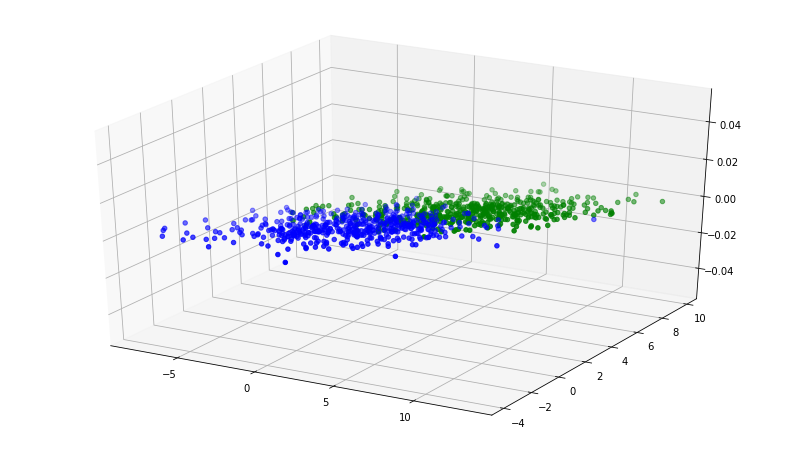

In [32]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_class_1[:,0], log_class_1[:,1], color='b', label='one')
ax.scatter(log_class_2[:,0], log_class_2[:,1], color='g', label='zero');

In [33]:
x_train = LOG[:int(len(LOG)*0.8), 0:3]
y_train = LOG[:int(len(LOG)*0.8), 3]
x_test = LOG[int(len(LOG)*0.8):, 0:3]
y_test = LOG[int(len(LOG)*0.8):, 3]

nb_model = NaiveBayesGaussian(k=2)
nb_model.fit(x_train,y_train)
pred_nb = nb_model.predict(x_test)
accuracy_nb = (pred_nb.ravel() == y_test).sum() / len(y_test) * 100
print("Naive Bayes accuracy:", accuracy_nb)

log_model = LogisticRegressionGD()
log_model.fit(x_train,y_train)
pred_log = log_model.predict(x_test)
accuracy_log = np.mean(pred_log == y_test) * 100
print("Logistic Regression accuracy:", accuracy_log)

Naive Bayes accuracy: 84.0
Logistic Regression accuracy: 88.0
